# Halo Model comparison with HMCODE and DARKEMU

This notebook make figure 6 of the halo model review `(Asgari,Heymans and Mead 2022)`
We compare matter-matter, matter-galaxy and galaxy-galaxy power spectra. Halo model predictions are calculated with and without the non-linear halo-halo power spectrum correction. The results are then compared with both HMCode ([Mead et. al. 2015](https://arxiv.org/abs/1505.07833), [2021](https://arxiv.org/abs/2009.01858)), an augmented halo model code which has been calibrated against simulations and DarkEmu which is an emulator for the Dark Quest simulations ([Nishimichi et al. 2019](https://arxiv.org/abs/1811.09504) and 
[Miyatake et al. 2020](https://arxiv.org/abs/2101.00113)). 

In [2]:
# Standard import
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import logging

# Third-party imports
import camb
# import pyhmcode as hmcode 
from dark_emulator import darkemu, model_hod

# Imports from the halo model repo
import halomodel
import DarkQuest
import utility_functions as utility
import constants as const

# Turn off matplotlib debug statements (caused by running Dark Quest)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

### Cosmlogical parameters
Lets set the cosmological parameters. The first set are the parameters that CAMB takes as input, but we also calculate a few derived parameters. If you want to set sigma_8 instead of As then set `sigma_8_set = True`

In [3]:
# Set cosmological parameters
Omega_c = 0.2537
Omega_b = 0.045
Omega_k = 0.0
h = 0.7
As = 2.1e-9
ns = 0.97
w = -1.0
wa = 0.0
m_nu = 0.06 # in eV

# derived parameters
wb   = Omega_b*h**2
wc   = Omega_c*h**2
Omega_nu_in =  m_nu/const.nuconst/h**2 # Note: this is very slightly different from what CAMB calculates
lnAs = np.log(1e10*As)
Omega_m_in = Omega_c + Omega_b + Omega_nu_in # Note: this is very slightly different from what CAMB calculates

# You can choose to set sigma_8, in that case we scale the power spectrum
sigma_8_set = True # if true uses the following value
sigma_8_in  = 0.7


### HOD and other parameters
Now lets set the parameters for the three methods that we want to compare. The critical linear over density, $\delta_{rm c}$= dc. The halo overdensity with respect to the background overdensity $\Delta_{\rm halo}$=Dv. Note that v in Dv stands for virial, but $\Delta_{\rm halo}$ is not always defined as the virial overdensity. 

In [4]:
# Wavenumbers
kmin = 1e-3
kmax = 20.

# redshift
zmin = 0. 
zmax = 2.
nz = 11
zs = np.linspace(zmin, zmax, nz)
z = 0.001 #This is the redshift where we do the comparison. Dark Quest doesn't like z=0

# HOD parameters
Mmin_HOD = 10**13
sigma_HOD = 0.5
M0_HOD = Mmin_HOD
M1_HOD = 10**14
alpha_HOD = 1.0


# Halo model parameters
Mmin = 1e3
Mmax = 1e17
nM = 120
Ms = utility.logspace(Mmin, Mmax, nM)
halomodel_version = 'Tinker et al. (2010)'
dc = 1.686 
Dv = 200.
Mdef = 'M200'
central_condition = True
consider_variance = True
add_shotnoise = False
discrete_gal = True

### CAMB
Lets run CAMB to the get the linear power spectrum. We can also get the nonlinear power spectra from CAMB and compare results with that. Currently we have set the nonlinear power to `mead2020` which is the 2020 version of HMcode without baryon feedback. Check [CAMB documentation](https://camb.readthedocs.io/en/latest/nonlinear.html?highlight=nonlinear#camb.nonlinear.NonLinearModel) for other options.

In [5]:
# Use CAMB to get the linear power spectrum and sigma(R)

# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=zs, kmax=kmax) # Setup the linear matter power spectrum

camb.set_params(halofit_version='mead2020')

# extract parameters from CAMB
Omega_m  = pars.omegam 
Omega_nu = pars.omeganu
Omega_L  = 1. + Omega_k - Omega_m
camb_results = camb.get_results(pars)
# get_sigma8 produces sigma_8(z)
sigma_8 = (camb_results.get_sigma8()[-1]).item()

if sigma_8_set:
    scaling = (sigma_8_in/sigma_8)**2
    As *= scaling
    lnAs = np.log(1e10*As)
    pars.InitPower.set_params(As=As, ns=ns, r=0)

Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear = False, 
                                            hubble_units = True, 
                                            k_hunit = True, 
                                            kmax = kmax,
                                            var1 = camb.model.Transfer_tot,
                                            var2 = camb.model.Transfer_tot, 
                                            zmax = zmax,
                                           )
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[-1]).item()

Pk_lin = Pk_lin.P # Single out the linear P(k) interpolator


# You can use this to find the non-linear powers spectra using CAMB. 
# In this notebook we use pyhmcode to get the non-linear power. 
# Create a power spectrum interpolation object from CAMB for the nonlinear power spectrum
Pk_nonlin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear = True, 
                                            hubble_units = True, 
                                            k_hunit = True, 
                                            kmax = kmax,
                                            var1 = camb.model.Transfer_tot,
                                            var2 = camb.model.Transfer_tot, 
                                            zmax = zmax,
                                           )
Pk_nonlin = Pk_nonlin.P

# Get CAMB P(k)
camb_results = camb.get_results(pars)
ks, zs, Pk = camb_results.get_linear_matter_power_spectrum(nonlinear=False)
#get an array for linear power from camb for the input resdhift, z. We are using the above line just to get ks
Pk_lin_camb = Pk_lin(z, ks) 
Pk_HMcode_mm = Pk_nonlin(z,ks)

Note: redshifts have been re-sorted (earliest first)


### Dark Emulator
Next lets setup the Dark Emulator

In [6]:
# Dark Quest

# Init HOD and cosmology
DQ_cosmo = DarkQuest.cosmology(wb=wb, wc=wc, Om_w=Omega_L, lnAs=lnAs, ns=ns, w=w)
emu = DarkQuest.init_emulator(DQ_cosmo)
hod = model_hod.darkemu_x_hod({"fft_num":8})
hod.set_cosmology(DQ_cosmo.cosmology_array())

# Set HOD
gparam = {"logMmin": np.log10(Mmin_HOD), 
          "sigma_sq": sigma_HOD**2, 
          "logM1": np.log10(M1_HOD), 
          "alpha": alpha_HOD, 
          "kappa": M0_HOD/Mmin_HOD,
          "poff": 0.0, # Fraction of off-centered galaxies.
          "Roff": 0.1, # Typical off-centered scale with respect to R200m.
          "sat_dist_type": "emulator", # Satellite distribution (emulator or NFW w/ DK2015 c-M relation).
          "alpha_inc": 0.0, # Incompleteness?
          "logM_inc": 13.57 # Incompleteness: For details, see More et al. (2015)
         } 
hod.set_galaxy(gparam)

# Get P(k) from Dark Quest
Pk_dq_mg = DarkQuest.get_p_gm(hod, ks, z)
Pk_dq_gg = DarkQuest.get_p_gg(hod, ks, z)
# We can get the matter power spectrum from the DarkEmu, but we will not use that in this demo
Pk_dq_mm = DarkQuest.get_Pk_mm(emu,ks, z,nonlinear=True)

Initialize Dark Quest
initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator

Dark Quest primary parameters
omega_b: 0.0220
omega_c: 0.1243
Omega_w: 0.7000
As [1e9]: 1.4560
ns: 0.9700
w: -1.0000

Dark Quest derived parameters
Omega_m: 0.3000
Omega_b: 0.0450
omega_m: 0.1470
h: 0.7000
Omega_c: 0.2537
Omega_nu: 0.0013
m_nu [eV]: 0.0596

Derived sigma_8: 0.699000058055297

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


### $\beta_{\rm nl}$

Now we calculate $\beta_{\rm nl}$ which is used to create the nonlinear halo-halo power spectra. With fill_value=None we extrapolate the beta_NL values via the nearest-neighbor extrapolation

In [7]:
# Beta-NL 
# Dark Quest parameters
Mmin_Bnl = 10**12.2
Mmax_Bnl = 10**15.1
nM_Bnl = 5
include_Bnl = True

if include_Bnl:
    Ms_Bnl = utility.logspace(Mmin_Bnl, Mmax_Bnl, nM_Bnl)
    beta_NL_small = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks, z,force_to_zero=6, mass_variable='Mass')
else:
    beta_NL = None


In [8]:
beta_NL = halomodel.RegularGridInterp_beta_NL(Ms_Bnl, ks,beta_NL_small,Ms,ks,method='linear')

### $\sigma(R)$
Get $\sigma(R)$ from CAMB. This is needed in the next step. 

In [9]:
# Get CAMB sigma(R)
# NOTE: Tricky with array ordering and needing to flip dimension on z
Rs = utility.Radius_M(Ms, Omega_m) # Lagrangian radii corresponding to halo masses
sigmaRs_camb = camb_results.get_sigmaR(Rs, hubble_units=True)
logsigmaR_interp = interp2d(np.log(Rs), np.flip(zs), np.log(sigmaRs_camb), kind='cubic')
sigmaRs = np.exp(logsigmaR_interp(np.log(Rs), z))

# Get sigma(R) using quad integration. Ignore the warning it is more accurate than CAMB, but slower
# sigmaRs_quad = utility.get_sigmaR(Rs,Pk_lin=lambda k: Pk_lin(0, k),integration_type='quad')
# sigmaRs = sigmaRs_quad
ks.max()

29.999998092651367

### Halo Model 
Now we initialise the halo model code and create power spectra

In [10]:
# Halo model

# Initialise halo model
hmod = halomodel.halomod(z, Omega_m, hm=halomodel_version, dc=dc, Dv=Dv, verbose=True)

# HOD
N_cen, N_sat = halomodel.HOD_Zheng(Ms, Mmin=Mmin_HOD, 
                                       sigma=sigma_HOD, 
                                       M0=M0_HOD, 
                                       M1=M1_HOD, 
                                       alpha=alpha_HOD)
if consider_variance:
    var_cen, var_sat, _ = halomodel.HOD_variance(N_cen, N_sat, central_condition)
else:
    var_cen = None; var_sat = None

# Halo window functions
nk = len(ks)
Uk = np.zeros((nM, nk))
Uk_cen = np.ones((nM, nk))
for iM, M in enumerate(Ms):
    c = halomodel.conc_Duffy(M, z, halo_definition=Mdef)
    rv = halomodel.virial_radius(M, hmod.Dv, Omega_m)
    Uk[iM, :] = halomodel.win_NFW(ks, rv, c)

# Densities
rhom = utility.comoving_matter_density(Omega_m)
rhog = halomodel.mean_hm(hmod, Ms, N_cen+N_sat, sigmas=sigmaRs)

# Halo profiles
# Note that you need mass=True for matter profiles, and discrete=True and some variance for galaxy profiles
profile_mat = halomodel.haloprof(ks, Ms, Ms, Uk, rhom, mass=True)
profile_cen = halomodel.haloprof(ks, Ms, N_cen, Uk_cen, rhog, var=var_cen, discrete=discrete_gal)
profile_sat = halomodel.haloprof(ks, Ms, N_sat, Uk, rhog, var=var_sat, discrete=discrete_gal)
profiles    = [profile_mat, profile_cen, profile_sat]

# Calculate (and organize) the halo-model power spectrum
for beta in [None, beta_NL]:
    Pk_2h, Pk_1h, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, profiles, 
                                          lambda k: Pk_lin(z, k), 
                                          sigmas = sigmaRs,
                                          beta   = beta,
                                          shot   = add_shotnoise,
                                          trunc_1halo = True,
                                          verbose= True)
    if beta is None:
        Pk_2h_mm = Pk_2h[0, 0, :]
        Pk_1h_mm = Pk_1h[0, 0, :]
        Pk_hm_mm = Pk_hm[0, 0, :]
        Pk_2h_gg = Pk_2h[1, 1, :]+2.*Pk_2h[1, 2, :]+Pk_2h[2, 2, :]
        Pk_1h_gg = Pk_1h[1, 1, :]+2.*Pk_1h[1, 2, :]+Pk_1h[2, 2, :]
        Pk_hm_gg = Pk_hm[1, 1, :]+2.*Pk_hm[1, 2, :]+Pk_hm[2, 2, :]
        Pk_2h_mg = Pk_2h[0, 1, :]+Pk_2h[0, 2, :]
        Pk_1h_mg = Pk_1h[0, 1, :]+Pk_1h[0, 2, :]
        Pk_hm_mg = Pk_hm[0, 1, :]+Pk_hm[0, 2, :]
    else:
        Pk_2h_bnl_mm = Pk_2h[0, 0, :]
        Pk_1h_bnl_mm = Pk_1h[0, 0, :]
        Pk_hm_bnl_mm = Pk_hm[0, 0, :]
        Pk_2h_bnl_gg = Pk_2h[1, 1, :]+2.*Pk_2h[1, 2, :]+Pk_2h[2, 2, :]
        Pk_1h_bnl_gg = Pk_1h[1, 1, :]+2.*Pk_1h[1, 2, :]+Pk_1h[2, 2, :]
        Pk_hm_bnl_gg = Pk_hm[1, 1, :]+2.*Pk_hm[1, 2, :]+Pk_hm[2, 2, :]
        Pk_2h_bnl_mg = Pk_2h[0, 1, :]+Pk_2h[0, 2, :]
        Pk_1h_bnl_mg = Pk_1h[0, 1, :]+Pk_1h[0, 2, :]
        Pk_hm_bnl_mg = Pk_hm[0, 1, :]+Pk_hm[0, 2, :]
# Note beta_nl has no impact on the 1 halo term. So all Pk_1h_bnl_* = Pk_1h_*

Initialising halo model
scale factor: 0.999
redshift: 0.001
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 200.0
Tinker et al. (2010) mass function
alpha: 0.368; beta: 0.589; gamma: 0.864; phi: -0.729; eta: -0.243
A: 1.000; a: 0.132
B: 0.183; b: 1.500
C: 0.265; c: 2.400

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.17923345883971586
Halomodel calculation time [s]: 0.1836380958557129 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.17923345883971586
Halomodel calculation time [s]: 72.44793915748596 



### Figure 6
Setup for plotting

In [11]:
# Parameters
kmin_plt = 1e-3; kmax_plt = 25
Pkmin = 1e0; Pkmax = 1e5
rmin = 0.79; rmax = 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True


# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_HMcode_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]
cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]


Now plot figure 6 of the Halo model Review.

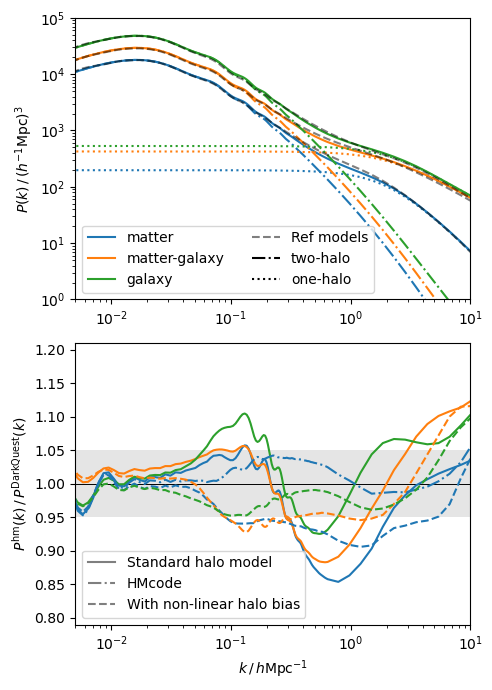

In [15]:
# Parameters
kmin_plt = 5e-3; kmax_plt = 1e1
Pkmin = 1e0; Pkmax = 1e5
rmin = 0.79; rmax = 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True

# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'Standard halo model'; lab_nl = 'With non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_HMcode_mm, Pk_dq_mg, Pk_dq_gg]
Pks_ref = [Pk_dq_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]

cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
    Pks_hybrid_bnl = [Pk_HMcode_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
#     Pks_hybrid_bnl = [Pk_HMcode_mm, Pk_hm_bnl_mg/Pk_hm_bnl_mm*Pk_HMcode_mm, Pk_hm_bnl_gg/Pk_hm_bnl_mm*Pk_HMcode_mm]
    Pks_hybrid_hm = [Pk_HMcode_mm, Pk_hm_mg/Pk_hm_mm*Pk_HMcode_mm, Pk_hm_gg/Pk_hm_mm*Pk_HMcode_mm]
    Pks_hybrid_dq = [Pk_HMcode_mm, Pk_dq_mg/Pk_dq_mm*Pk_HMcode_mm, Pk_dq_gg/Pk_dq_mm*Pk_HMcode_mm]
    Pks_hybrid_bnl_dq = [Pk_HMcode_mm, Pk_hm_bnl_mg/Pk_dq_mm*Pk_HMcode_mm, Pk_hm_bnl_gg/Pk_dq_mm*Pk_HMcode_mm]

Pks_hybrid = Pks_hybrid_bnl.copy()

# Initialise
plt.subplots(2, 1, figsize=(5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

plt.plot(np.nan, ls='--', color='black',alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')


# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pk_HMcode_mm, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

plt.plot(ks, Pk_HMcode_mm/Pk_dq_mm, color=col_mm, ls="-.")


# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_nl_res)
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
plt.plot(np.nan, color='black', alpha=0.5, ls="-.", label="HMcode")
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label=lab_nl)
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{DarkQuest}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()

The top plot shows the power spectra from the standard halo model (solid) and the reference models (dashed). The 1 and 2 halo term contributions to the halo model are shown separately. 
For the bottom plot we show ratios of the halo model predictions with respect to reference power spectra.
The reference values come from HMcode for matter power spectrum and the Dark Emulator for galaxy and galaxy-matter power spectra. We show the result for both the standrad and with non-linear halo bias correction halo models.